In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from simulators.cosmic_shear.cosmic_shear import *
import ndes.nde as nde
import distributions.priors as priors

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
### SET UP FOR SIMULATION CODE ###

# n(z)
#pz_fid = pickle.load(open('pz_euclid.pkl', 'rb'))
nz = 10
pz = np.loadtxt('simulators/cosmic_shear/pz.dat')
z = pz[0,:]
pz_fid = [0]*nz
for i in range(1, nz+1):
    pz_fid[i-1] = interpolate.InterpolatedUnivariateSpline(z, pz[i,:])

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5
n_data = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

# Parameter names and ranges for plotting  
names = ['\Omega_m', 'S_8', '\Omega_b', 'h', 'n_s']
labels =  ['\\Omega_m', 'S_8', '\\Omega_b', 'h', 'n_s']
ranges = {'\Omega_m':[lower[0], upper[0]], 'S_8':[lower[1],upper[1]],'\Omega_b':[lower[2],upper[2]],
            'h':[lower[3],upper[3]],'n_s':[lower[4],upper[4]]}

# Scale binning
lmax = 3000
lmin = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), 11)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz_fid, modes, N, nl]

# Fiducial power spectrum
C = power_spectrum(theta_fiducial, sim_args)
Cinv = np.array([np.linalg.inv(C[:,:,l]) for l in range(len(modes))]).T

# Derivative of power spectrum
h = np.array(abs(theta_fiducial[0:5])*np.array([0.05, 0.05, 0.05, 0.05, 0.05]))
dCdt = np.zeros((npar, nz, nz, len(modes)))

# Derivatives wrt cosmological parameters
for i in range(npar):
    theta_plus = np.copy(theta_fiducial)
    theta_plus[i] += h[i]
    theta_minus = np.copy(theta_fiducial)
    theta_minus[i] -= h[i]
    
    Cp = power_spectrum(theta_plus, [pz_fid, modes, np.zeros((nz, nz))])
    Cm = power_spectrum(theta_minus, [pz_fid, modes, np.zeros((nz, nz))])
    C0 = power_spectrum(theta_fiducial, [pz_fid, modes, np.zeros((nz, nz))])

    dCdt[i, :, :, :] = (Cp - Cm)/(2*h[i])

# Fisher matrix
F, Finv, fisher_errors = fisher_matrix(Cinv, dCdt, npar, nl, Qinv)

# Projection arguments
projection_args = [Finv, 0, theta_fiducial, fisher_errors, prior_mean, Qinv, Cinv, dCdt, modes, nl]

# SimABC args
simABC_args = [sim_args, projection_args, prior_args]

In [4]:
# Define the simulator function: takes parameters, spits out simulated (compressed) summaries
simulator = lambda x: simulationABC(x, simABC_args)

In [5]:
# The data vector: import or otherwise simulate for testing
data = projected_score(power_spectrum(theta_fiducial, sim_args), projection_args)

In [6]:
# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

# Create asymptotic posterior approximation
asymptotic_posterior = priors.TruncatedGaussian(theta_fiducial, Finv, lower, upper)

In [7]:
# Create the DELFI MDN object
n_components = 3

mdn = nde.DelfiMixtureDensityNetwork(simulator, prior, asymptotic_posterior, Finv, theta_fiducial, data, n_components, n_hidden = [50, 50], activations = ['tanh', 'tanh'], names = names, labels = labels, ranges = ranges)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 63)                3213      
Total params: 6,063
Trainable params: 6,063
Non-trainable params: 0
_________________________________________________________________


Generating pre-training data...
Training on the pre-training data...
Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 3s 57us/step - loss: -360301.2606 - val_loss: -1752565.9650
Epoch 2/50
45000/45000 [==============================] - 4s 80us/step - loss: -5867280.4844 - val_loss: -11899481.8400
Epoch 3/50
45000/45000 [==============================] - 4s 83us/step - loss: -22415905.8711 - val_loss: -35708785.9200
Epoch 4/50
45000/45000 [==============================] - 4s 81us/step - loss: -54669054.0089 - val_loss: -76993279.3600
Epoch 5/50
45000/45000 [==============================] - 4s 83us/step - loss: -105720791.7689 - val_loss: -138245337.2800
Epoch 6/50
45000/45000 [==============================] - 4s 78us/step - loss: -177652957.1911 - val_loss: -221212892.8000
Epoch 7/50
45000/45000 [==============================] - 3s 74us/step - loss: -272007549.9378 - val_loss: -327273840.0000
Epoch 8/50
45000/45000 [=========

Saving fish_pretrain_post.pdf


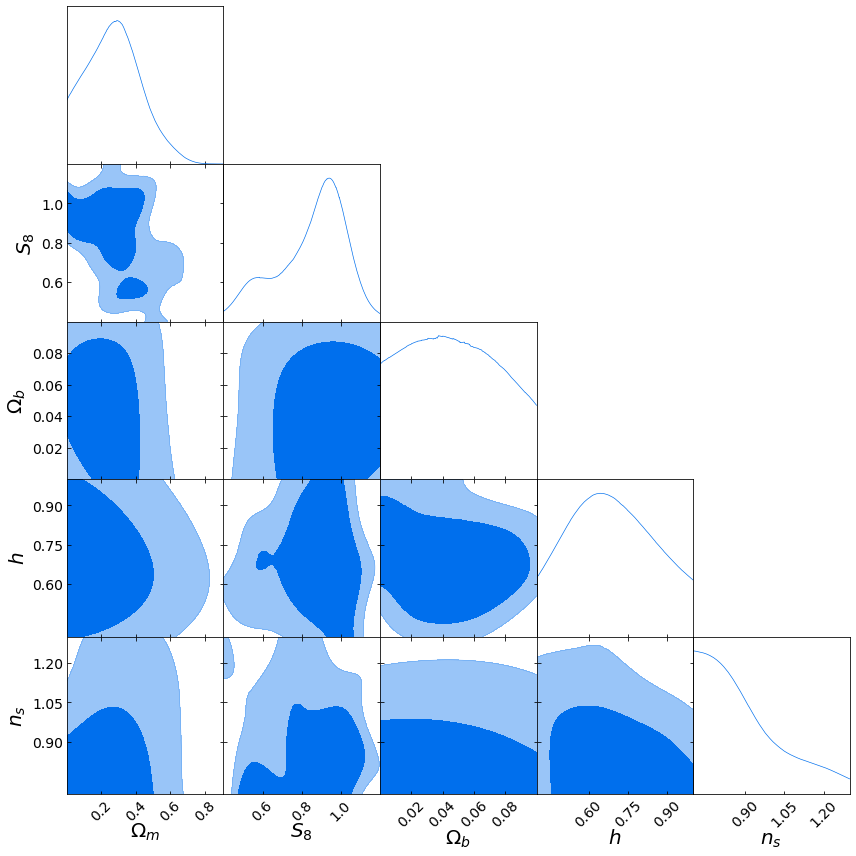

In [8]:
# Do the Fisher pre-training
mdn.fisher_pretraining(50000, prior, epochs=50)

Running initial 500 sims...
Simulator returns exception for parameter values: [0.2794824  0.79694196 0.01500385 0.55742195 0.97666862] (rank 0)
Simulator returns exception for parameter values: [0.31091883 0.80540539 0.06385287 0.62249122 1.01581714] (rank 0)
Simulator returns exception for parameter values: [0.29099882 0.80051264 0.07953525 0.8128836  0.95635467] (rank 0)
Simulator returns exception for parameter values: [0.32425831 0.79824071 0.07998399 0.72935385 1.00650995] (rank 0)
Simulator returns exception for parameter values: [0.29800226 0.79852716 0.02874052 0.43771403 1.06595421] (rank 0)
Simulator returns exception for parameter values: [0.30045565 0.80295305 0.00616647 0.46997969 0.97311922] (rank 0)
Simulator returns exception for parameter values: [0.28199365 0.79725486 0.02633869 0.63298154 0.97061456] (rank 0)
Simulator returns exception for parameter values: [0.28352747 0.79503735 0.02543238 0.64050531 0.95449089] (rank 0)
Simulator returns exception for parameter va

Simulator returns exception for parameter values: [0.29405121 0.79613453 0.03320741 0.7764939  0.91274153] (rank 0)
Simulator returns exception for parameter values: [0.30559424 0.80019916 0.05440002 0.78378636 0.92348462] (rank 0)
Simulator returns exception for parameter values: [0.29015322 0.80113202 0.0606972  0.90331504 0.88271028] (rank 0)
Simulator returns exception for parameter values: [0.29312029 0.79727264 0.00136784 0.45670136 1.0034013 ] (rank 0)
Simulator returns exception for parameter values: [0.30698346 0.80200485 0.02249058 0.59953242 0.94929147] (rank 0)
Simulator returns exception for parameter values: [0.2922195  0.80079897 0.09229078 0.80349132 0.99850418] (rank 0)
Simulator returns exception for parameter values: [0.29610551 0.80148852 0.07483208 0.90258832 0.90933718] (rank 0)
Simulator returns exception for parameter values: [0.30277084 0.80118794 0.04581302 0.61246958 0.99349034] (rank 0)
Simulator returns exception for parameter values: [0.31713966 0.80266863

Simulator returns exception for parameter values: [0.28575737 0.79558146 0.08556876 0.87710105 0.9742479 ] (rank 0)
Simulator returns exception for parameter values: [0.29452273 0.80014672 0.07142062 0.86306234 0.9283533 ] (rank 0)
Simulator returns exception for parameter values: [0.29476869 0.79705266 0.03688928 0.72433751 0.92999524] (rank 0)
Simulator returns exception for parameter values: [0.3105283  0.79769912 0.0774288  0.91503002 0.89908896] (rank 0)
Simulator returns exception for parameter values: [0.29970605 0.79845679 0.07093648 0.84105006 0.94276623] (rank 0)
Simulator returns exception for parameter values: [0.28732715 0.8009792  0.05970859 0.64070919 1.0122687 ] (rank 0)
Simulator returns exception for parameter values: [0.29656986 0.79481089 0.01257125 0.5728695  0.95675782] (rank 0)
Simulator returns exception for parameter values: [0.30057615 0.79515678 0.07412168 0.87064338 0.9471015 ] (rank 0)
Simulator returns exception for parameter values: [0.31373803 0.79755131

Simulator returns exception for parameter values: [0.27945463 0.79260253 0.0418213  0.94687832 0.84595358] (rank 0)
Simulator returns exception for parameter values: [0.29836109 0.79575107 0.00366203 0.61154882 0.9268102 ] (rank 0)
Simulator returns exception for parameter values: [0.30231794 0.80088248 0.06328731 0.92796035 0.85816456] (rank 0)
Simulator returns exception for parameter values: [0.31426259 0.80307325 0.04925702 0.72153935 0.92425581] (rank 0)
Simulator returns exception for parameter values: [0.30986052 0.80103299 0.06368902 0.74134387 0.95802658] (rank 0)
Simulator returns exception for parameter values: [0.29539547 0.79589568 0.0639881  0.76582197 0.97669996] (rank 0)
Simulator returns exception for parameter values: [0.29295435 0.79487226 0.07805957 0.81597262 0.98252867] (rank 0)
Simulator returns exception for parameter values: [0.29647401 0.80036587 0.01518593 0.48481982 0.98643928] (rank 0)
Simulator returns exception for parameter values: [0.30803113 0.80424095

Simulator returns exception for parameter values: [0.28692579 0.7997472  0.07363195 0.94232816 0.89140847] (rank 0)
Simulator returns exception for parameter values: [0.30847391 0.80433394 0.06190647 0.82046187 0.90614444] (rank 0)
Simulator returns exception for parameter values: [0.29369244 0.8053516  0.01846255 0.60105515 0.92592102] (rank 0)
Simulator returns exception for parameter values: [0.30126816 0.79358298 0.08911759 0.89774227 0.96145451] (rank 0)
Simulator returns exception for parameter values: [0.28204707 0.79788491 0.03529818 0.58987141 1.01395754] (rank 0)
Simulator returns exception for parameter values: [0.31383766 0.80420724 0.00887001 0.52577549 0.95374446] (rank 0)
Simulator returns exception for parameter values: [0.31521001 0.79923194 0.041005   0.74422336 0.89987551] (rank 0)
Simulator returns exception for parameter values: [0.32576725 0.80003223 0.05429236 0.74151211 0.91901268] (rank 0)
Simulator returns exception for parameter values: [0.31483109 0.80375975

Simulator returns exception for parameter values: [0.2831652  0.79650668 0.0668522  0.88866605 0.91326648] (rank 0)
Simulator returns exception for parameter values: [0.30190767 0.79768915 0.06106664 0.73869283 0.96709318] (rank 0)
Simulator returns exception for parameter values: [0.29855488 0.80028017 0.0497289  0.80056874 0.90993973] (rank 0)
Simulator returns exception for parameter values: [0.29723583 0.79691428 0.00883692 0.46491133 1.00302911] (rank 0)
Simulator returns exception for parameter values: [0.28919673 0.80080167 0.05220576 0.74755858 0.93029098] (rank 0)
Simulator returns exception for parameter values: [0.31272019 0.80358403 0.05554858 0.51006982 1.05941742] (rank 0)
Simulator returns exception for parameter values: [0.29817895 0.79407574 0.00972417 0.50367275 0.9977811 ] (rank 0)
Simulator returns exception for parameter values: [0.3076859  0.79973463 0.08494429 0.73661188 1.02721117] (rank 0)
Simulator returns exception for parameter values: [0.29679699 0.80103885

Simulator returns exception for parameter values: [0.31427481 0.80216512 0.00663567 0.47923753 0.98441185] (rank 0)
Simulator returns exception for parameter values: [0.32086958 0.79974947 0.02106899 0.43607636 1.03572871] (rank 0)
Simulator returns exception for parameter values: [0.31168807 0.79743476 0.04686812 0.64802963 0.97627557] (rank 0)
Simulator returns exception for parameter values: [0.29395269 0.79720659 0.05350263 0.78769775 0.9297608 ] (rank 0)
Simulator returns exception for parameter values: [0.30289207 0.80505014 0.07020661 0.83585273 0.90756431] (rank 0)
Simulator returns exception for parameter values: [0.30486838 0.80470545 0.00277576 0.51564171 0.93766082] (rank 0)
Simulator returns exception for parameter values: [0.29203845 0.79987216 0.06673326 0.78465205 0.95260663] (rank 0)
Simulator returns exception for parameter values: [0.29961169 0.79627417 0.09562835 0.88874744 0.98556369] (rank 0)
Simulator returns exception for parameter values: [0.30731867 0.80117942

Simulator returns exception for parameter values: [0.27852318 0.79820761 0.03482423 0.64501451 0.97476892] (rank 0)
Simulator returns exception for parameter values: [0.31742617 0.79734232 0.04727926 0.77504313 0.90933404] (rank 0)
Simulator returns exception for parameter values: [0.28583906 0.79816264 0.05339147 0.87469367 0.88313616] (rank 0)
Simulator returns exception for parameter values: [0.30575911 0.80377603 0.0931967  0.82349236 0.96695221] (rank 0)
Simulator returns exception for parameter values: [0.2903872  0.80204839 0.03550418 0.75631657 0.90456924] (rank 0)
Simulator returns exception for parameter values: [0.27958448 0.79501923 0.01093868 0.5045969  1.00956016] (rank 0)
Simulator returns exception for parameter values: [0.30690338 0.80229756 0.07491953 0.84503865 0.91602448] (rank 0)
Simulator returns exception for parameter values: [0.28699243 0.79789022 0.03495698 0.68254478 0.94734168] (rank 0)
Simulator returns exception for parameter values: [0.29079977 0.80327557

Simulator returns exception for parameter values: [0.29213847 0.79856383 0.01942835 0.52740695 0.98926044] (rank 0)
Simulator returns exception for parameter values: [0.2852775  0.79881206 0.05430927 0.81218601 0.93034199] (rank 0)
Simulator returns exception for parameter values: [0.29931623 0.80345364 0.01481444 0.61717344 0.91566957] (rank 0)
Simulator returns exception for parameter values: [0.29556429 0.80081042 0.01299952 0.6213397  0.91164214] (rank 0)
Simulator returns exception for parameter values: [0.31170275 0.8028117  0.04013697 0.57552276 0.98475153] (rank 0)
Simulator returns exception for parameter values: [0.30454498 0.80244782 0.06666704 0.83791866 0.92321588] (rank 0)
Simulator returns exception for parameter values: [0.29478672 0.79791161 0.04908735 0.4721589  1.0945463 ] (rank 0)
Simulator returns exception for parameter values: [0.28023103 0.79913693 0.04240371 0.79355898 0.90911241] (rank 0)
Simulator returns exception for parameter values: [0.28896326 0.79878947

Simulator returns exception for parameter values: [0.29237733 0.799932   0.02638921 0.56561242 1.0041603 ] (rank 0)
Simulator returns exception for parameter values: [0.30589616 0.80129271 0.03292989 0.65182642 0.9388891 ] (rank 0)
Simulator returns exception for parameter values: [0.29980625 0.80028278 0.06923091 0.85073902 0.92204271] (rank 0)
Simulator returns exception for parameter values: [0.31622885 0.79787076 0.09319521 0.75294178 1.02327899] (rank 0)
Simulator returns exception for parameter values: [0.29602915 0.80012395 0.02881235 0.59793428 0.98135249] (rank 0)
Simulator returns exception for parameter values: [0.28760031 0.79933885 0.05247856 0.85321767 0.89839347] (rank 0)
Simulator returns exception for parameter values: [0.30178034 0.80053356 0.02608233 0.54191188 0.99148563] (rank 0)
Simulator returns exception for parameter values: [0.30121146 0.80156564 0.05694763 0.76130098 0.94334693] (rank 0)
Simulator returns exception for parameter values: [0.29703199 0.79904235

Epoch 45/100
450/450 [==============================] - 0s 66us/step - loss: -46189578467.5556 - val_loss: -46206832640.0000
Epoch 46/100
450/450 [==============================] - 0s 66us/step - loss: -46216345827.5556 - val_loss: -46233604096.0000
Epoch 47/100
450/450 [==============================] - 0s 88us/step - loss: -46243122744.8889 - val_loss: -46260383744.0000
Epoch 48/100
450/450 [==============================] - 0s 62us/step - loss: -46269903303.1111 - val_loss: -46287159296.0000
Epoch 49/100
450/450 [==============================] - 0s 60us/step - loss: -46296684771.5556 - val_loss: -46313934848.0000
Epoch 50/100
450/450 [==============================] - 0s 61us/step - loss: -46323461688.8889 - val_loss: -46340718592.0000
Epoch 51/100
450/450 [==============================] - 0s 86us/step - loss: -46350233600.0000 - val_loss: -46367490048.0000
Epoch 52/100
450/450 [==============================] - 0s 62us/step - loss: -46377011427.5556 - val_loss: -46394261504.0000


Saving seq_train_post_0.pdf


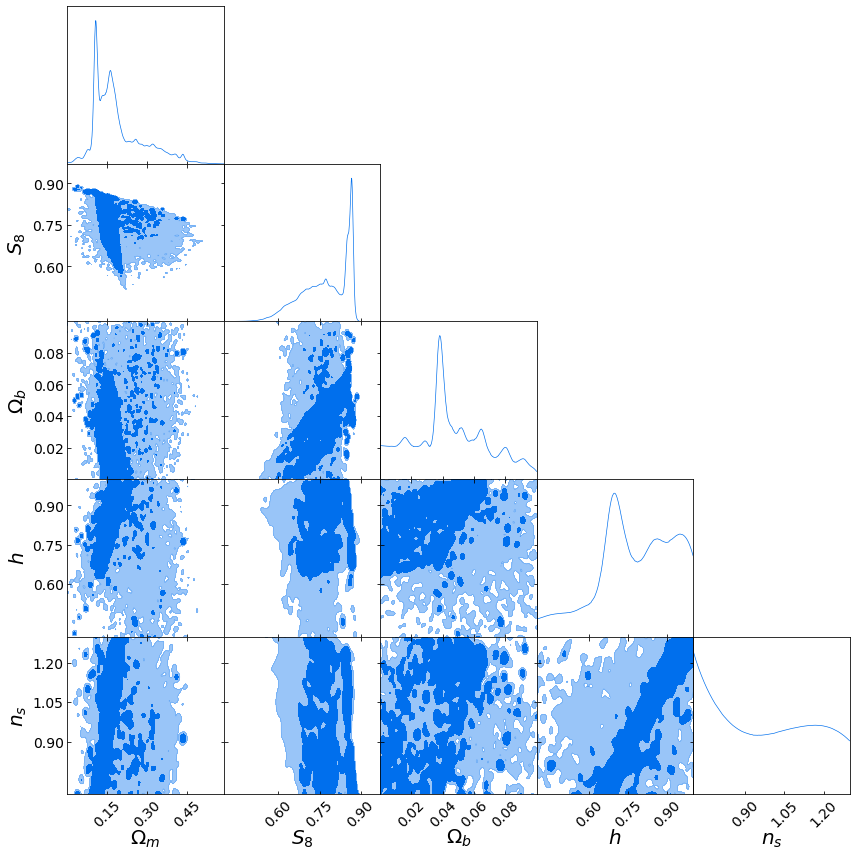

Population 1/15
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.33909432 0.73852943 0.08067083 0.95257485 0.94401358] (rank 0)
Simulator returns exception for parameter values: [0.33909432 0.73852943 0.08067083 0.95257485 0.94401358] (rank 0)
Simulator returns exception for parameter values: [0.33909432 0.73852943 0.08067083 0.95257485 0.94401358] (rank 0)
Simulator returns exception for parameter values: [0.33909432 0.73852943 0.08067083 0.95257485 0.94401358] (rank 0)
Simulator returns exception for parameter values: [0.30666095 0.74716746 0.06196153 0.85668613 1.00108636] (rank 0)
Simulator returns exception for parameter values: [0.29337132 0.74500203 0.06746948 0.90568668 0.98345967] (rank 0)
Simulator returns exception for parameter values: [0.29337132 0.74500203 0.06746948 0.90568668 0.98345967] (rank 0)
Simulator returns exception for parameter values: [0.29337132 0.74500203 0.06746948 0.90568668 0.98345967] (rank 0)
S

Simulator returns exception for parameter values: [0.38176983 0.66730095 0.01289508 0.78673095 1.13256911] (rank 0)
Simulator returns exception for parameter values: [0.36174421 0.66972445 0.01588304 0.77719979 1.12950956] (rank 0)
Simulator returns exception for parameter values: [0.35945645 0.63948211 0.00735857 0.83264217 1.16143786] (rank 0)
Simulator returns exception for parameter values: [0.35945645 0.63948211 0.00735857 0.83264217 1.16143786] (rank 0)
Simulator returns exception for parameter values: [0.36704393 0.63618762 0.00657097 0.82702051 1.17028451] (rank 0)
Simulator returns exception for parameter values: [0.36704393 0.63618762 0.00657097 0.82702051 1.17028451] (rank 0)
Simulator returns exception for parameter values: [0.37354767 0.64368172 0.01307765 0.78480059 1.17924216] (rank 0)
Simulator returns exception for parameter values: [0.386142   0.63847309 0.01095948 0.80902224 1.17736269] (rank 0)
Simulator returns exception for parameter values: [0.386142   0.63847309

Simulator returns exception for parameter values: [0.22791923 0.80381692 0.0589948  0.89744802 1.1202719 ] (rank 0)
Simulator returns exception for parameter values: [0.22791923 0.80381692 0.0589948  0.89744802 1.1202719 ] (rank 0)
Simulator returns exception for parameter values: [0.22791923 0.80381692 0.0589948  0.89744802 1.1202719 ] (rank 0)
Simulator returns exception for parameter values: [0.16898283 0.82291166 0.04635241 0.97911705 1.24244428] (rank 0)
Simulator returns exception for parameter values: [0.16898283 0.82291166 0.04635241 0.97911705 1.24244428] (rank 0)
Simulator returns exception for parameter values: [0.16898283 0.82291166 0.04635241 0.97911705 1.24244428] (rank 0)
Simulator returns exception for parameter values: [0.16898283 0.82291166 0.04635241 0.97911705 1.24244428] (rank 0)
Simulator returns exception for parameter values: [0.16898283 0.82291166 0.04635241 0.97911705 1.24244428] (rank 0)
Simulator returns exception for parameter values: [0.16898283 0.82291166

Simulator returns exception for parameter values: [0.19249628 0.81966939 0.07268347 0.81992916 0.7344227 ] (rank 0)
Simulator returns exception for parameter values: [0.19990005 0.81702664 0.07162521 0.81323161 0.73927284] (rank 0)
Simulator returns exception for parameter values: [0.19990005 0.81702664 0.07162521 0.81323161 0.73927284] (rank 0)
Simulator returns exception for parameter values: [0.19990005 0.81702664 0.07162521 0.81323161 0.73927284] (rank 0)
Simulator returns exception for parameter values: [0.25912501 0.80304814 0.05118464 0.72156854 0.97690444] (rank 0)
Simulator returns exception for parameter values: [0.27424179 0.79212731 0.05620418 0.77550912 1.02133414] (rank 0)
Simulator returns exception for parameter values: [0.34344313 0.76815478 0.0619003  0.94277494 0.98941371] (rank 0)
Simulator returns exception for parameter values: [0.34344313 0.76815478 0.0619003  0.94277494 0.98941371] (rank 0)
Simulator returns exception for parameter values: [0.35829919 0.77061927

Simulator returns exception for parameter values: [0.41737522 0.76160963 0.08226355 0.6711076  1.05487757] (rank 0)
Simulator returns exception for parameter values: [0.32953717 0.7833663  0.06633957 0.57563667 1.0959678 ] (rank 0)
Simulator returns exception for parameter values: [0.29353692 0.79484047 0.06980444 0.55151954 1.07245475] (rank 0)
Simulator returns exception for parameter values: [0.29233448 0.7872934  0.07638299 0.55900805 1.03656166] (rank 0)
Simulator returns exception for parameter values: [0.29233448 0.7872934  0.07638299 0.55900805 1.03656166] (rank 0)
Simulator returns exception for parameter values: [0.22728334 0.81716831 0.05802741 0.53016734 1.10361149] (rank 0)
Simulator returns exception for parameter values: [0.22149396 0.82660975 0.05784977 0.50841237 1.09045811] (rank 0)
Simulator returns exception for parameter values: [0.22149396 0.82660975 0.05784977 0.50841237 1.09045811] (rank 0)
Simulator returns exception for parameter values: [0.22149396 0.82660975

Simulator returns exception for parameter values: [0.19938188 0.8409047  0.0813834  0.56376867 1.03482631] (rank 0)
Simulator returns exception for parameter values: [0.19938188 0.8409047  0.0813834  0.56376867 1.03482631] (rank 0)
Simulator returns exception for parameter values: [0.19938188 0.8409047  0.0813834  0.56376867 1.03482631] (rank 0)
Simulator returns exception for parameter values: [0.20770106 0.83751662 0.07956227 0.5689548  1.02388685] (rank 0)
Simulator returns exception for parameter values: [0.21198689 0.83411512 0.07806588 0.56695361 1.02640457] (rank 0)
Simulator returns exception for parameter values: [0.21438054 0.83179094 0.07742259 0.56577501 1.02447242] (rank 0)
Simulator returns exception for parameter values: [0.21438054 0.83179094 0.07742259 0.56577501 1.02447242] (rank 0)
Simulator returns exception for parameter values: [0.18075218 0.83538484 0.09682379 0.5072495  1.06921768] (rank 0)
Simulator returns exception for parameter values: [0.18075218 0.83538484

Simulator returns exception for parameter values: [0.30740349 0.76260541 0.03766523 0.49254918 1.08473718] (rank 0)
Simulator returns exception for parameter values: [0.30986413 0.75240972 0.0430444  0.50154292 1.09345275] (rank 0)
Simulator returns exception for parameter values: [0.30986413 0.75240972 0.0430444  0.50154292 1.09345275] (rank 0)
Simulator returns exception for parameter values: [0.30986413 0.75240972 0.0430444  0.50154292 1.09345275] (rank 0)
Simulator returns exception for parameter values: [0.34088408 0.78916998 0.05280386 0.77411869 0.76842552] (rank 0)
Simulator returns exception for parameter values: [0.34088408 0.78916998 0.05280386 0.77411869 0.76842552] (rank 0)
Simulator returns exception for parameter values: [0.34088408 0.78916998 0.05280386 0.77411869 0.76842552] (rank 0)
Simulator returns exception for parameter values: [0.34088408 0.78916998 0.05280386 0.77411869 0.76842552] (rank 0)
Simulator returns exception for parameter values: [0.34088408 0.78916998

Simulator returns exception for parameter values: [0.26095219 0.81854704 0.03642736 0.66633443 0.81554958] (rank 0)
Simulator returns exception for parameter values: [0.26095219 0.81854704 0.03642736 0.66633443 0.81554958] (rank 0)
Simulator returns exception for parameter values: [0.26095219 0.81854704 0.03642736 0.66633443 0.81554958] (rank 0)
Simulator returns exception for parameter values: [0.26095219 0.81854704 0.03642736 0.66633443 0.81554958] (rank 0)
Simulator returns exception for parameter values: [0.41937074 0.77157061 0.03208898 0.50092055 0.77970378] (rank 0)
Simulator returns exception for parameter values: [0.41937074 0.77157061 0.03208898 0.50092055 0.77970378] (rank 0)
Simulator returns exception for parameter values: [0.41937074 0.77157061 0.03208898 0.50092055 0.77970378] (rank 0)
Simulator returns exception for parameter values: [0.41837713 0.76912469 0.03299267 0.50723842 0.78390049] (rank 0)
Simulator returns exception for parameter values: [0.42222924 0.76866986

900/900 [==============================] - 0s 56us/step - loss: -47702016910.2222 - val_loss: -47728893952.0000
Epoch 2/100
900/900 [==============================] - 0s 94us/step - loss: -47750394766.2222 - val_loss: -47777292288.0000
Epoch 3/100
900/900 [==============================] - 0s 48us/step - loss: -47798804480.0000 - val_loss: -47825686528.0000
Epoch 4/100
900/900 [==============================] - 0s 53us/step - loss: -47847226936.8889 - val_loss: -47874142208.0000
Epoch 5/100
900/900 [==============================] - 0s 40us/step - loss: -47895675790.2222 - val_loss: -47922601984.0000
Epoch 6/100
900/900 [==============================] - 0s 45us/step - loss: -47944137386.6667 - val_loss: -47971065856.0000
Epoch 7/100
900/900 [==============================] - 0s 37us/step - loss: -47992609450.6667 - val_loss: -48019533824.0000
Epoch 8/100
900/900 [==============================] - 0s 35us/step - loss: -48041089251.5556 - val_loss: -48068030464.0000
Epoch 9/100
900/900 

900/900 [==============================] - 0s 52us/step - loss: -50889588280.8889 - val_loss: -50917277696.0000
Epoch 67/100
900/900 [==============================] - 0s 50us/step - loss: -50939426588.4444 - val_loss: -50967121920.0000
Epoch 68/100
900/900 [==============================] - 0s 48us/step - loss: -50989289016.8889 - val_loss: -51016998912.0000
Epoch 69/100
900/900 [==============================] - 0s 50us/step - loss: -51039181482.6667 - val_loss: -51066904576.0000
Epoch 70/100
900/900 [==============================] - 0s 48us/step - loss: -51089095338.6667 - val_loss: -51116843008.0000
Epoch 71/100
900/900 [==============================] - 0s 46us/step - loss: -51139039232.0000 - val_loss: -51166781440.0000
Epoch 72/100
900/900 [==============================] - 0s 50us/step - loss: -51189009066.6667 - val_loss: -51216781312.0000
Epoch 73/100
900/900 [==============================] - 0s 41us/step - loss: -51239024412.4444 - val_loss: -51266813952.0000
Epoch 74/100


Saving seq_train_post_1.pdf


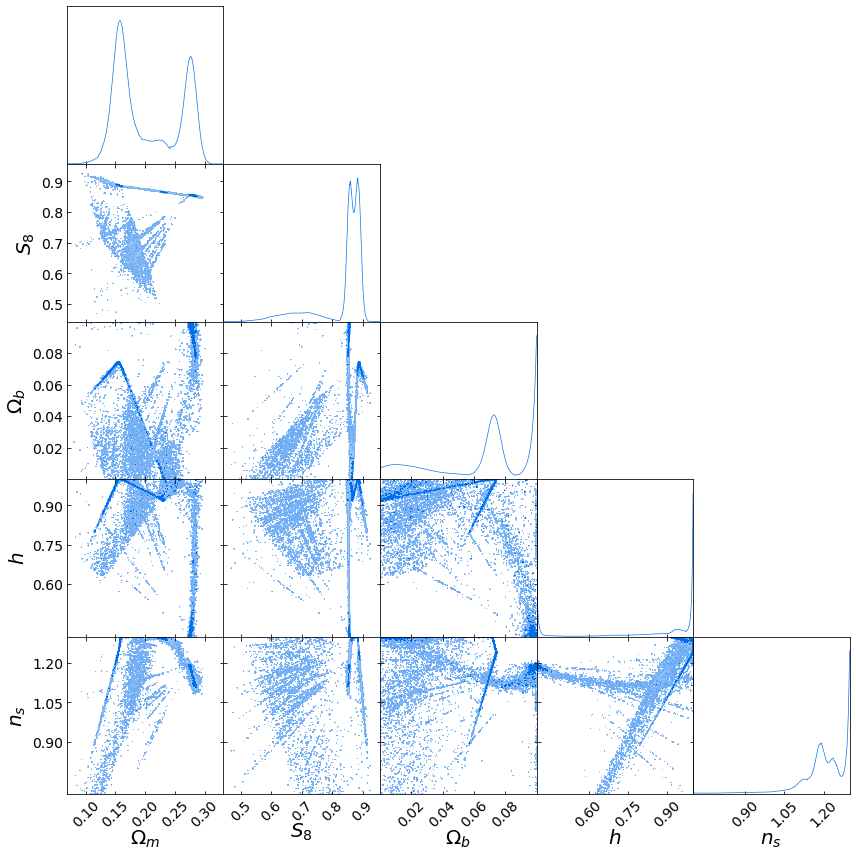

Population 2/15
Sampling proposal density...
Done.
Running 500 sims...
Simulator returns exception for parameter values: [0.22150244 0.87923768 0.04458508 0.82525576 1.16889716] (rank 0)
Simulator returns exception for parameter values: [0.23211262 0.87481129 0.04855943 0.84661232 1.15679781] (rank 0)
Simulator returns exception for parameter values: [0.23211262 0.87481129 0.04855943 0.84661232 1.15679781] (rank 0)
Simulator returns exception for parameter values: [0.23211262 0.87481129 0.04855943 0.84661232 1.15679781] (rank 0)
Simulator returns exception for parameter values: [0.24865845 0.86723709 0.05934535 0.67279434 1.19556047] (rank 0)
Simulator returns exception for parameter values: [0.25078275 0.86625529 0.05597856 0.68571364 1.18466381] (rank 0)
Simulator returns exception for parameter values: [0.25078275 0.86625529 0.05597856 0.68571364 1.18466381] (rank 0)
Simulator returns exception for parameter values: [0.25078275 0.86625529 0.05597856 0.68571364 1.18466381] (rank 0)
S

Simulator returns exception for parameter values: [0.28041428 0.85455513 0.09141557 0.61139907 1.13764436] (rank 0)
Simulator returns exception for parameter values: [0.28041428 0.85455513 0.09141557 0.61139907 1.13764436] (rank 0)
Simulator returns exception for parameter values: [0.28036781 0.8546104  0.08665736 0.58613274 1.15127119] (rank 0)
Simulator returns exception for parameter values: [0.28036781 0.8546104  0.08665736 0.58613274 1.15127119] (rank 0)
Simulator returns exception for parameter values: [0.28052251 0.85461531 0.08565113 0.57589823 1.15413141] (rank 0)
Simulator returns exception for parameter values: [0.28052251 0.85461531 0.08565113 0.57589823 1.15413141] (rank 0)
Simulator returns exception for parameter values: [0.28052251 0.85461531 0.08565113 0.57589823 1.15413141] (rank 0)
Simulator returns exception for parameter values: [0.28052251 0.85461531 0.08565113 0.57589823 1.15413141] (rank 0)
Simulator returns exception for parameter values: [0.28052251 0.85461531

Simulator returns exception for parameter values: [0.25623814 0.86153808 0.04694655 0.68468021 1.17797906] (rank 0)
Simulator returns exception for parameter values: [0.26488302 0.85903971 0.04965578 0.66542641 1.17980229] (rank 0)
Simulator returns exception for parameter values: [0.26488302 0.85903971 0.04965578 0.66542641 1.17980229] (rank 0)
Simulator returns exception for parameter values: [0.27514997 0.85592108 0.04822194 0.71380529 1.16397981] (rank 0)
Simulator returns exception for parameter values: [0.27514997 0.85592108 0.04822194 0.71380529 1.16397981] (rank 0)
Simulator returns exception for parameter values: [0.27514997 0.85592108 0.04822194 0.71380529 1.16397981] (rank 0)
Simulator returns exception for parameter values: [0.27514997 0.85592108 0.04822194 0.71380529 1.16397981] (rank 0)
Simulator returns exception for parameter values: [0.27514997 0.85592108 0.04822194 0.71380529 1.16397981] (rank 0)
Simulator returns exception for parameter values: [0.27514997 0.85592108

Simulator returns exception for parameter values: [0.21987948 0.75874423 0.07885194 0.76630346 0.79838083] (rank 0)
Simulator returns exception for parameter values: [0.21987948 0.75874423 0.07885194 0.76630346 0.79838083] (rank 0)
Simulator returns exception for parameter values: [0.21987948 0.75874423 0.07885194 0.76630346 0.79838083] (rank 0)
Simulator returns exception for parameter values: [0.21987948 0.75874423 0.07885194 0.76630346 0.79838083] (rank 0)
Simulator returns exception for parameter values: [0.21987948 0.75874423 0.07885194 0.76630346 0.79838083] (rank 0)
Simulator returns exception for parameter values: [0.21987948 0.75874423 0.07885194 0.76630346 0.79838083] (rank 0)
Simulator returns exception for parameter values: [0.21909917 0.73651683 0.08369272 0.77542266 0.71917554] (rank 0)
Simulator returns exception for parameter values: [0.21909917 0.73651683 0.08369272 0.77542266 0.71917554] (rank 0)
Simulator returns exception for parameter values: [0.21909917 0.73651683

Simulator returns exception for parameter values: [0.28005478 0.85492076 0.08085605 0.44093461 1.20121465] (rank 0)
Simulator returns exception for parameter values: [0.27975903 0.8550328  0.08282691 0.42194024 1.20425464] (rank 0)
Simulator returns exception for parameter values: [0.27859267 0.85530476 0.08714908 0.40684482 1.20678922] (rank 0)
Simulator returns exception for parameter values: [0.27859267 0.85530476 0.08714908 0.40684482 1.20678922] (rank 0)
Simulator returns exception for parameter values: [0.27859267 0.85530476 0.08714908 0.40684482 1.20678922] (rank 0)
Simulator returns exception for parameter values: [0.278045   0.85560147 0.08624653 0.40807048 1.20197771] (rank 0)
Simulator returns exception for parameter values: [0.278045   0.85560147 0.08624653 0.40807048 1.20197771] (rank 0)
Simulator returns exception for parameter values: [0.278045   0.85560147 0.08624653 0.40807048 1.20197771] (rank 0)
Simulator returns exception for parameter values: [0.09522466 0.91347935

Simulator returns exception for parameter values: [0.27876709 0.8550098  0.07449158 0.51979477 1.18077955] (rank 0)
Simulator returns exception for parameter values: [0.27901791 0.85500215 0.07413754 0.51692754 1.1835556 ] (rank 0)
Simulator returns exception for parameter values: [0.27897328 0.85503083 0.07659543 0.5088625  1.18334472] (rank 0)
Simulator returns exception for parameter values: [0.19952909 0.87882305 0.03348022 0.76264327 1.17893253] (rank 0)
Simulator returns exception for parameter values: [0.19952909 0.87882305 0.03348022 0.76264327 1.17893253] (rank 0)
Simulator returns exception for parameter values: [0.19952909 0.87882305 0.03348022 0.76264327 1.17893253] (rank 0)
Simulator returns exception for parameter values: [0.19952909 0.87882305 0.03348022 0.76264327 1.17893253] (rank 0)
Simulator returns exception for parameter values: [0.20455367 0.87686982 0.03373674 0.7779754  1.18980814] (rank 0)
Simulator returns exception for parameter values: [0.20770658 0.87597527

Simulator returns exception for parameter values: [0.28499812 0.85353685 0.05564016 0.62547529 1.16357629] (rank 0)
Simulator returns exception for parameter values: [0.28461317 0.85359232 0.05673441 0.62286826 1.16542911] (rank 0)
Simulator returns exception for parameter values: [0.28461317 0.85359232 0.05673441 0.62286826 1.16542911] (rank 0)
Simulator returns exception for parameter values: [0.29035121 0.85219201 0.05830253 0.59988103 1.15676368] (rank 0)
Simulator returns exception for parameter values: [0.28471768 0.85363474 0.06010506 0.55759274 1.18061   ] (rank 0)
Simulator returns exception for parameter values: [0.28471768 0.85363474 0.06010506 0.55759274 1.18061   ] (rank 0)
Simulator returns exception for parameter values: [0.28471768 0.85363474 0.06010506 0.55759274 1.18061   ] (rank 0)
Simulator returns exception for parameter values: [0.28471768 0.85363474 0.06010506 0.55759274 1.18061   ] (rank 0)
Simulator returns exception for parameter values: [0.28471768 0.85363474

Simulator returns exception for parameter values: [0.28322629 0.85511704 0.04339025 0.65335642 1.12760268] (rank 0)
Simulator returns exception for parameter values: [0.28322629 0.85511704 0.04339025 0.65335642 1.12760268] (rank 0)
Simulator returns exception for parameter values: [0.28322629 0.85511704 0.04339025 0.65335642 1.12760268] (rank 0)
Simulator returns exception for parameter values: [0.28499756 0.85364578 0.04538969 0.65977578 1.15945308] (rank 0)
Simulator returns exception for parameter values: [0.28463049 0.85357127 0.05156493 0.62771298 1.17339615] (rank 0)
Simulator returns exception for parameter values: [0.28591149 0.85327821 0.05214725 0.61944085 1.17148965] (rank 0)
Simulator returns exception for parameter values: [0.28357155 0.85385371 0.05537652 0.60525167 1.17834468] (rank 0)
Simulator returns exception for parameter values: [0.28357155 0.85385371 0.05537652 0.60525167 1.17834468] (rank 0)
Simulator returns exception for parameter values: [0.28357155 0.85385371

Simulator returns exception for parameter values: [0.26859026 0.85800502 0.0479999  0.65425286 1.18359251] (rank 0)
Simulator returns exception for parameter values: [0.26859026 0.85800502 0.0479999  0.65425286 1.18359251] (rank 0)
Simulator returns exception for parameter values: [0.26859026 0.85800502 0.0479999  0.65425286 1.18359251] (rank 0)
Simulator returns exception for parameter values: [0.26859026 0.85800502 0.0479999  0.65425286 1.18359251] (rank 0)
Simulator returns exception for parameter values: [0.26859026 0.85800502 0.0479999  0.65425286 1.18359251] (rank 0)
Simulator returns exception for parameter values: [0.27645133 0.85565363 0.04967622 0.66972798 1.17611727] (rank 0)
Simulator returns exception for parameter values: [0.2780119  0.85531707 0.05046625 0.66013888 1.17221377] (rank 0)
Simulator returns exception for parameter values: [0.2780119  0.85531707 0.05046625 0.66013888 1.17221377] (rank 0)
Simulator returns exception for parameter values: [0.27956635 0.85481777

1350/1350 [==============================] - 0s 81us/step - loss: -53616865735.1111 - val_loss: -53661044736.0000
Epoch 14/100
1350/1350 [==============================] - 0s 93us/step - loss: -53696800995.5556 - val_loss: -53741019136.0000
Epoch 15/100
1350/1350 [==============================] - 0s 88us/step - loss: -53776818327.7037 - val_loss: -53821083648.0000
Epoch 16/100
1350/1350 [==============================] - 0s 91us/step - loss: -53856915152.5926 - val_loss: -53901230080.0000
Epoch 17/100
1350/1350 [==============================] - 0s 87us/step - loss: -53937087829.3333 - val_loss: -53981446144.0000
Epoch 18/100
1350/1350 [==============================] - 0s 89us/step - loss: -54017334385.7778 - val_loss: -54061731840.0000
Epoch 19/100
1350/1350 [==============================] - 0s 88us/step - loss: -54097648146.9630 - val_loss: -54142096725.3333
Epoch 20/100
1350/1350 [==============================] - 0s 98us/step - loss: -54178041552.5926 - val_loss: -54222524416.00

1350/1350 [==============================] - 0s 84us/step - loss: -58885640495.4074 - val_loss: -58932536661.3333
Epoch 78/100
1350/1350 [==============================] - 0s 84us/step - loss: -58970479881.4815 - val_loss: -59017428992.0000
Epoch 79/100
1350/1350 [==============================] - 0s 83us/step - loss: -59055398760.2963 - val_loss: -59102370474.6667
Epoch 80/100
1350/1350 [==============================] - 0s 87us/step - loss: -59140384388.7407 - val_loss: -59187400704.0000
Epoch 81/100
1350/1350 [==============================] - 0s 62us/step - loss: -59225442228.1481 - val_loss: -59272501930.6667
Epoch 82/100
1350/1350 [==============================] - 0s 68us/step - loss: -59310574402.3704 - val_loss: -59357679616.0000
Epoch 83/100
1350/1350 [==============================] - 0s 72us/step - loss: -59395785462.5185 - val_loss: -59442929664.0000
Epoch 84/100
1350/1350 [==============================] - 0s 66us/step - loss: -59481067671.7037 - val_loss: -59528257536.00

/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/mcsamples.py:1674: RuntimeWarning: divide by zero encountered in true_divide
  corrected = (bins2D[ix] * A + xP * Ax + yP * Ay) / denom
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/mcsamples.py:1674: RuntimeWarning: invalid value encountered in true_divide
  corrected = (bins2D[ix] * A + xP * Ax + yP * Ay) / denom
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/charnock/.pyenv/versions/3.6.6/lib/python3.6/site-packages/getdist/mcsamples.py:1688: RuntimeWarning: invalid value encountered in greater
  ix2 = bins2D > np.max(bins2D) * 1e-8


DensitiesError: Contour level outside plotted ranges

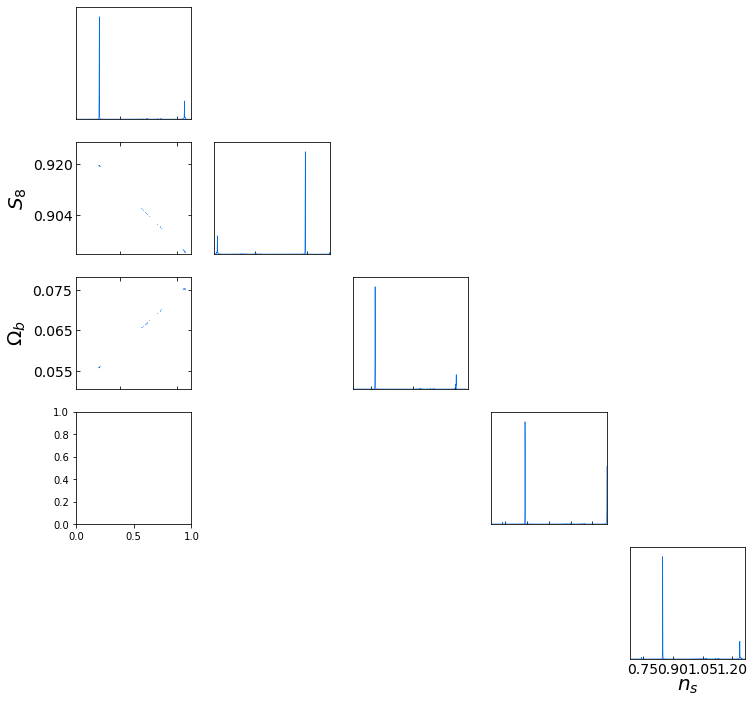

In [9]:
# Proposal for the SNL
proposal = priors.TruncatedGaussian(theta_fiducial, 9*Finv, lower, upper)

# Initial samples, batch size for population samples, number of populations
n_initial = 500
n_batch = 500
n_populations = 15

# Do the SNL training
mdn.sequential_training(n_initial, n_batch, n_populations, proposal)

In [ ]:
# Trace plot of the loss as a function of the number of simulations
plt.scatter(mdn.n_sim_trace, mdn.loss_trace, s = 20)
plt.plot(mdn.n_sim_trace, mdn.loss_trace, color = 'red')
plt.xlim(0, mdn.n_sim_trace[-1])
plt.xlabel('number of simulations')
plt.ylabel('loss')
plt.show()